# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [24]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as ss
import prettytable
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.model_selection import cross_validate
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.metrics import roc_curve,roc_auc_score,auc
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import cross_validate
import re # Go to https://pymotw.com/2/re/
import string
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from tqdm import tqdm
import os

In [25]:
#Loading the dataset that we cleaned in TSNE project
df = pd.read_csv(r'C:\Users\nihar\affrd_cleaned_preprocessed.csv')

In [26]:
df['Score'].value_counts() #counting the number of positive and negative datapoints

positive    307061
negative     57110
Name: Score, dtype: int64

In [27]:
#randomly sampling positive and negative datapoints and from the dataframe 'df' and creating new data frame total_points
positive_points = df[df['Score'] == 'positive'].sample(n=2500, random_state=0)#randomly sampling 20k positive points
negative_points = df[df['Score'] == 'negative'].sample(n=2500, random_state=0)# randomly sampling 20k negative points
total_points = pd.concat([positive_points, negative_points])#concatenating the positive_points and negative_points dataframe

# Sorting based on time
sorted_data = total_points.sort_values('Time', #Here we are sorting filtered_data according to Time in 
                                       axis = 0,    #- ascending order so that we can do time based splitting later.
                                     inplace = False, #inpace = false because we dont want to make modifications in-
                                      #- fitered data rather we want to keep filtered_data preserved and store the modified-
                                      #- data in sorted_data
                                    kind = 'quicksort',
                                     na_position = 'last')
sorted_data['Score'].value_counts()
sorted_data.to_csv('sorted_data_df.csv')
sorted_data = pd.read_csv('sorted_data_df.csv')

In [28]:
sorted_data.shape

(5000, 13)

In [29]:
x=sorted_data['CleanedText']

In [30]:
x.shape

(5000,)

# 2. Bag of words (BOW)

In [31]:
#Bag of words
#Applying Bag of words on train datapoint dataset 'x_train'
vectorizer = CountVectorizer(min_df = 50) #defining our BOW model here. Here we are considering words which occur more than-
#-50 times in our document.
model = vectorizer.fit(x)#learning the internal parameters (here vocabulary) of text(i.e reviews) in x_train
print(vectorizer.vocabulary_) #visulaizing the vocabulary

{'cant': 93, 'watch': 635, 'time': 604, 'one': 401, 'ever': 200, 'made': 351, 'mix': 373, 'along': 15, 'thing': 597, 'world': 656, 'live': 342, 'recent': 475, 'wait': 631, 'hous': 292, 'year': 663, 'peopl': 422, 'come': 129, 'tri': 613, 'break': 76, 'take': 583, 'place': 432, 'excel': 205, 'see': 508, 'definit': 164, 'often': 398, 'think': 598, 'suppos': 576, 'like': 337, 'help': 281, 'make': 352, 'also': 17, 'feel': 224, 'great': 264, 'product': 458, 'valu': 626, 'everyon': 202, 'famili': 216, 'love': 348, 'chees': 105, 'especi': 197, 'french': 245, 'receiv': 474, 'gift': 253, 'realli': 472, 'favorit': 222, 'rich': 489, 'flavor': 237, 'back': 45, 'day': 159, 'way': 637, 'wife': 649, 'ate': 38, 'much': 378, 'smaller': 534, 'never': 385, 'either': 190, 'say': 503, 'becom': 55, 'even': 199, 'perfect': 425, 'appl': 30, 'bread': 75, 'special': 553, 'share': 519, 'friend': 247, 'wonder': 653, 'life': 335, 'open': 403, 'use': 624, 'decid': 163, 'delici': 165, 'enjoy': 194, 'fresh': 246, 'pas

In [32]:
x_bow = model.transform(x)#converting the internal parameters(i.e vocab) into vectors
x_bow_df = pd.DataFrame(x_bow.toarray(),columns = model.get_feature_names())
standardized_x = StandardScaler().fit_transform(x_bow_df)

C:\Users\nihar\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\nihar\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [33]:
### 2.1 K-Means on BOW
k=[1,2,3,4,5,6,7,8]
dic=dict()
for i in k:
    clf=KMeans(n_clusters=i)
    clf.fit(standardized_x)
    dic[i] = clf.inertia_

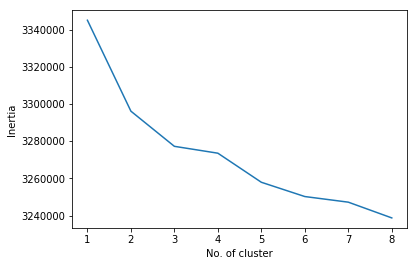

In [34]:
plt.plot(list(dic.keys()), list(dic.values()))
plt.xlabel("No. of cluster")
plt.ylabel("Inertia")
plt.show()

### Observation
<pre>The best value of k=3</pre>

In [35]:
clf = KMeans(n_clusters = 3)
clf.fit(standardized_x)
pred=clf.predict(standardized_x)

In [36]:
#Plot each cluster features in a cloud
def plot_cluster_cloud(features, coef):
    coef_df = pd.DataFrame(coef, columns = features)
    print(len(coef_df))
    # Create a figure and set of 15 subplots because our k range is in between 
    fig, axes = plt.subplots(5, 3, figsize = (30, 20))
    fig.suptitle("Top 20 words for each cluster ", fontsize = 50)
    cent = range(len(coef_df))
    for ax, i in zip(axes.flat, cent):
        wordcloud = WordCloud(background_color = "white").generate_from_frequencies(coef_df.iloc[i,:].sort_values(ascending = False)[0:20])
        ax.imshow(wordcloud)
        ax.set_title("Cluster {} word cloud".format(i+1), fontsize = 30)
        ax.axis("off")
    plt.tight_layout()
    fig.subplots_adjust(top = 0.90)
    plt.show()

3


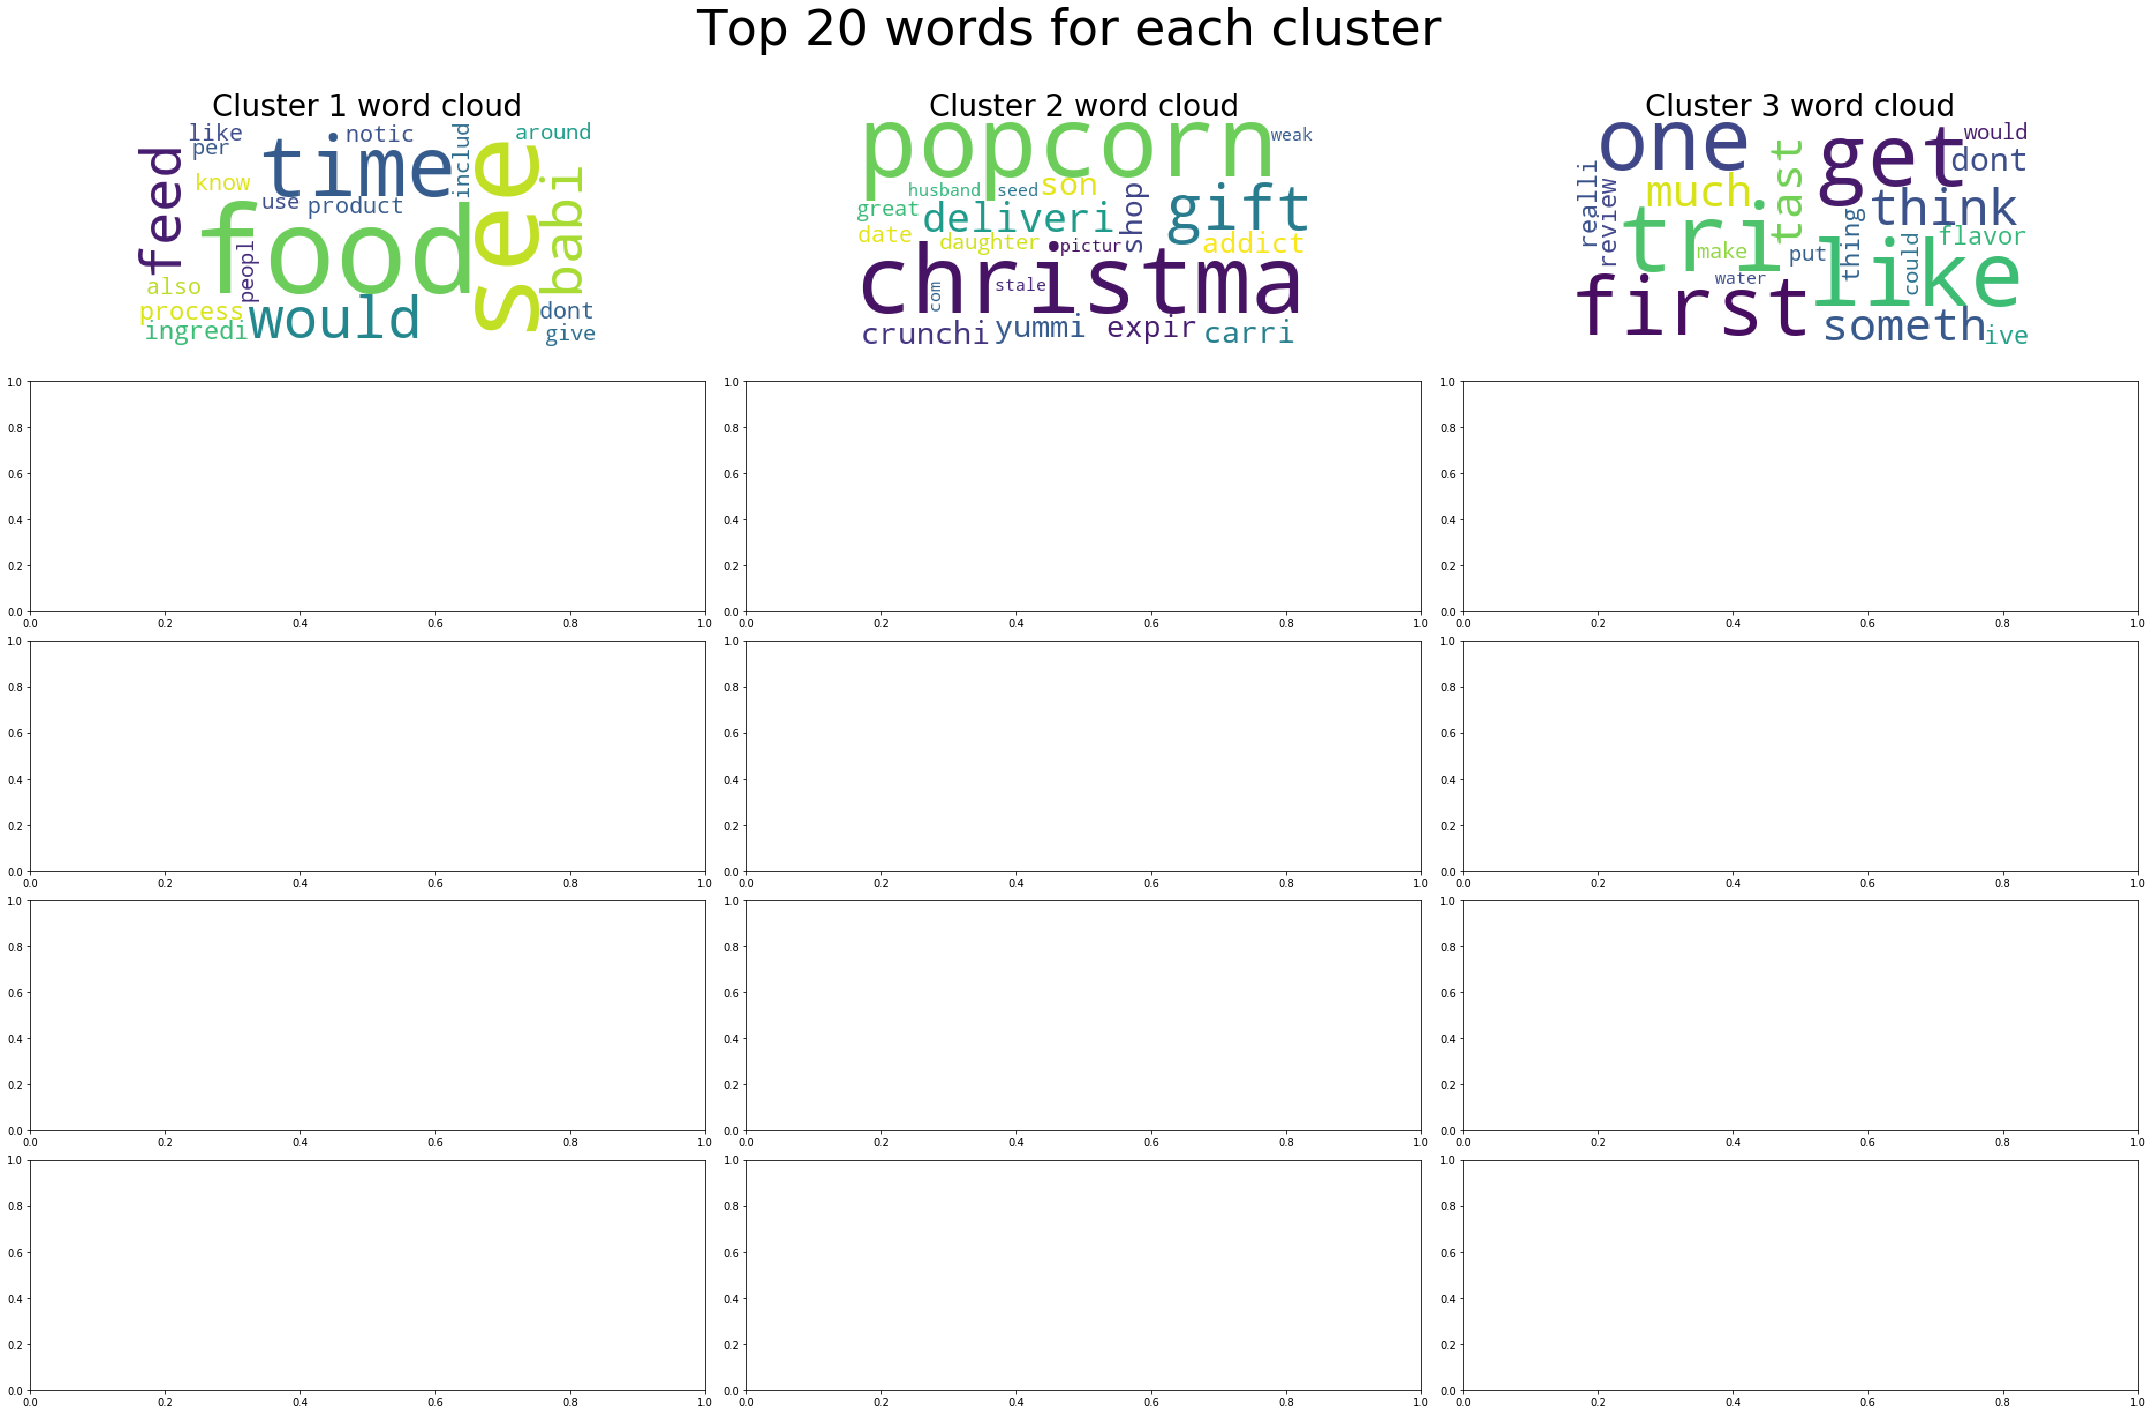

In [37]:
# getting feature names in features 
# and the cluster centers in coef
# Plot the all cluster with their corresponding features
features = model.get_feature_names()
coef = clf.cluster_centers_
plot_cluster_cloud(features, coef)#will get us top 20 words in each cluster

## 3. TFIDF

In [38]:
#tf-idf on train dataset
vectorizer = TfidfVectorizer(min_df = 50)#defining our tf-idf model and considering only those words which occur more than 10-
#times in our document
model = vectorizer.fit(x)#Here we are learning the internal parameters (i.e vocabulary) of our train dataset-
#- (i.e. review text)
print(vectorizer.vocabulary_) #visualizing the parameters learnt (i.e vocabulary)

{'cant': 93, 'watch': 635, 'time': 604, 'one': 401, 'ever': 200, 'made': 351, 'mix': 373, 'along': 15, 'thing': 597, 'world': 656, 'live': 342, 'recent': 475, 'wait': 631, 'hous': 292, 'year': 663, 'peopl': 422, 'come': 129, 'tri': 613, 'break': 76, 'take': 583, 'place': 432, 'excel': 205, 'see': 508, 'definit': 164, 'often': 398, 'think': 598, 'suppos': 576, 'like': 337, 'help': 281, 'make': 352, 'also': 17, 'feel': 224, 'great': 264, 'product': 458, 'valu': 626, 'everyon': 202, 'famili': 216, 'love': 348, 'chees': 105, 'especi': 197, 'french': 245, 'receiv': 474, 'gift': 253, 'realli': 472, 'favorit': 222, 'rich': 489, 'flavor': 237, 'back': 45, 'day': 159, 'way': 637, 'wife': 649, 'ate': 38, 'much': 378, 'smaller': 534, 'never': 385, 'either': 190, 'say': 503, 'becom': 55, 'even': 199, 'perfect': 425, 'appl': 30, 'bread': 75, 'special': 553, 'share': 519, 'friend': 247, 'wonder': 653, 'life': 335, 'open': 403, 'use': 624, 'decid': 163, 'delici': 165, 'enjoy': 194, 'fresh': 246, 'pas

In [39]:
x_tfidf = model.transform(x)
x_tfidf_df = pd.DataFrame(x_tfidf.toarray(),columns = model.get_feature_names())
standardized_x = StandardScaler().fit_transform(x_tfidf_df)

In [40]:
### 2.1 K-Means on BOW
k=[1,2,3,4,5,6,7,8]
dic=dict()
for i in k:
    clf=KMeans(n_clusters=i)
    clf.fit(standardized_x)
    dic[i] = clf.inertia_

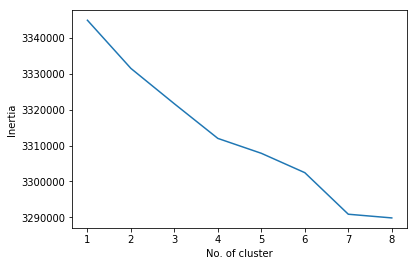

In [41]:
plt.plot(list(dic.keys()), list(dic.values()))
plt.xlabel("No. of cluster")
plt.ylabel("Inertia")
plt.show()

In [42]:
clf = KMeans(n_clusters = 7)
clf.fit(standardized_x)
pred=clf.predict(standardized_x)

7


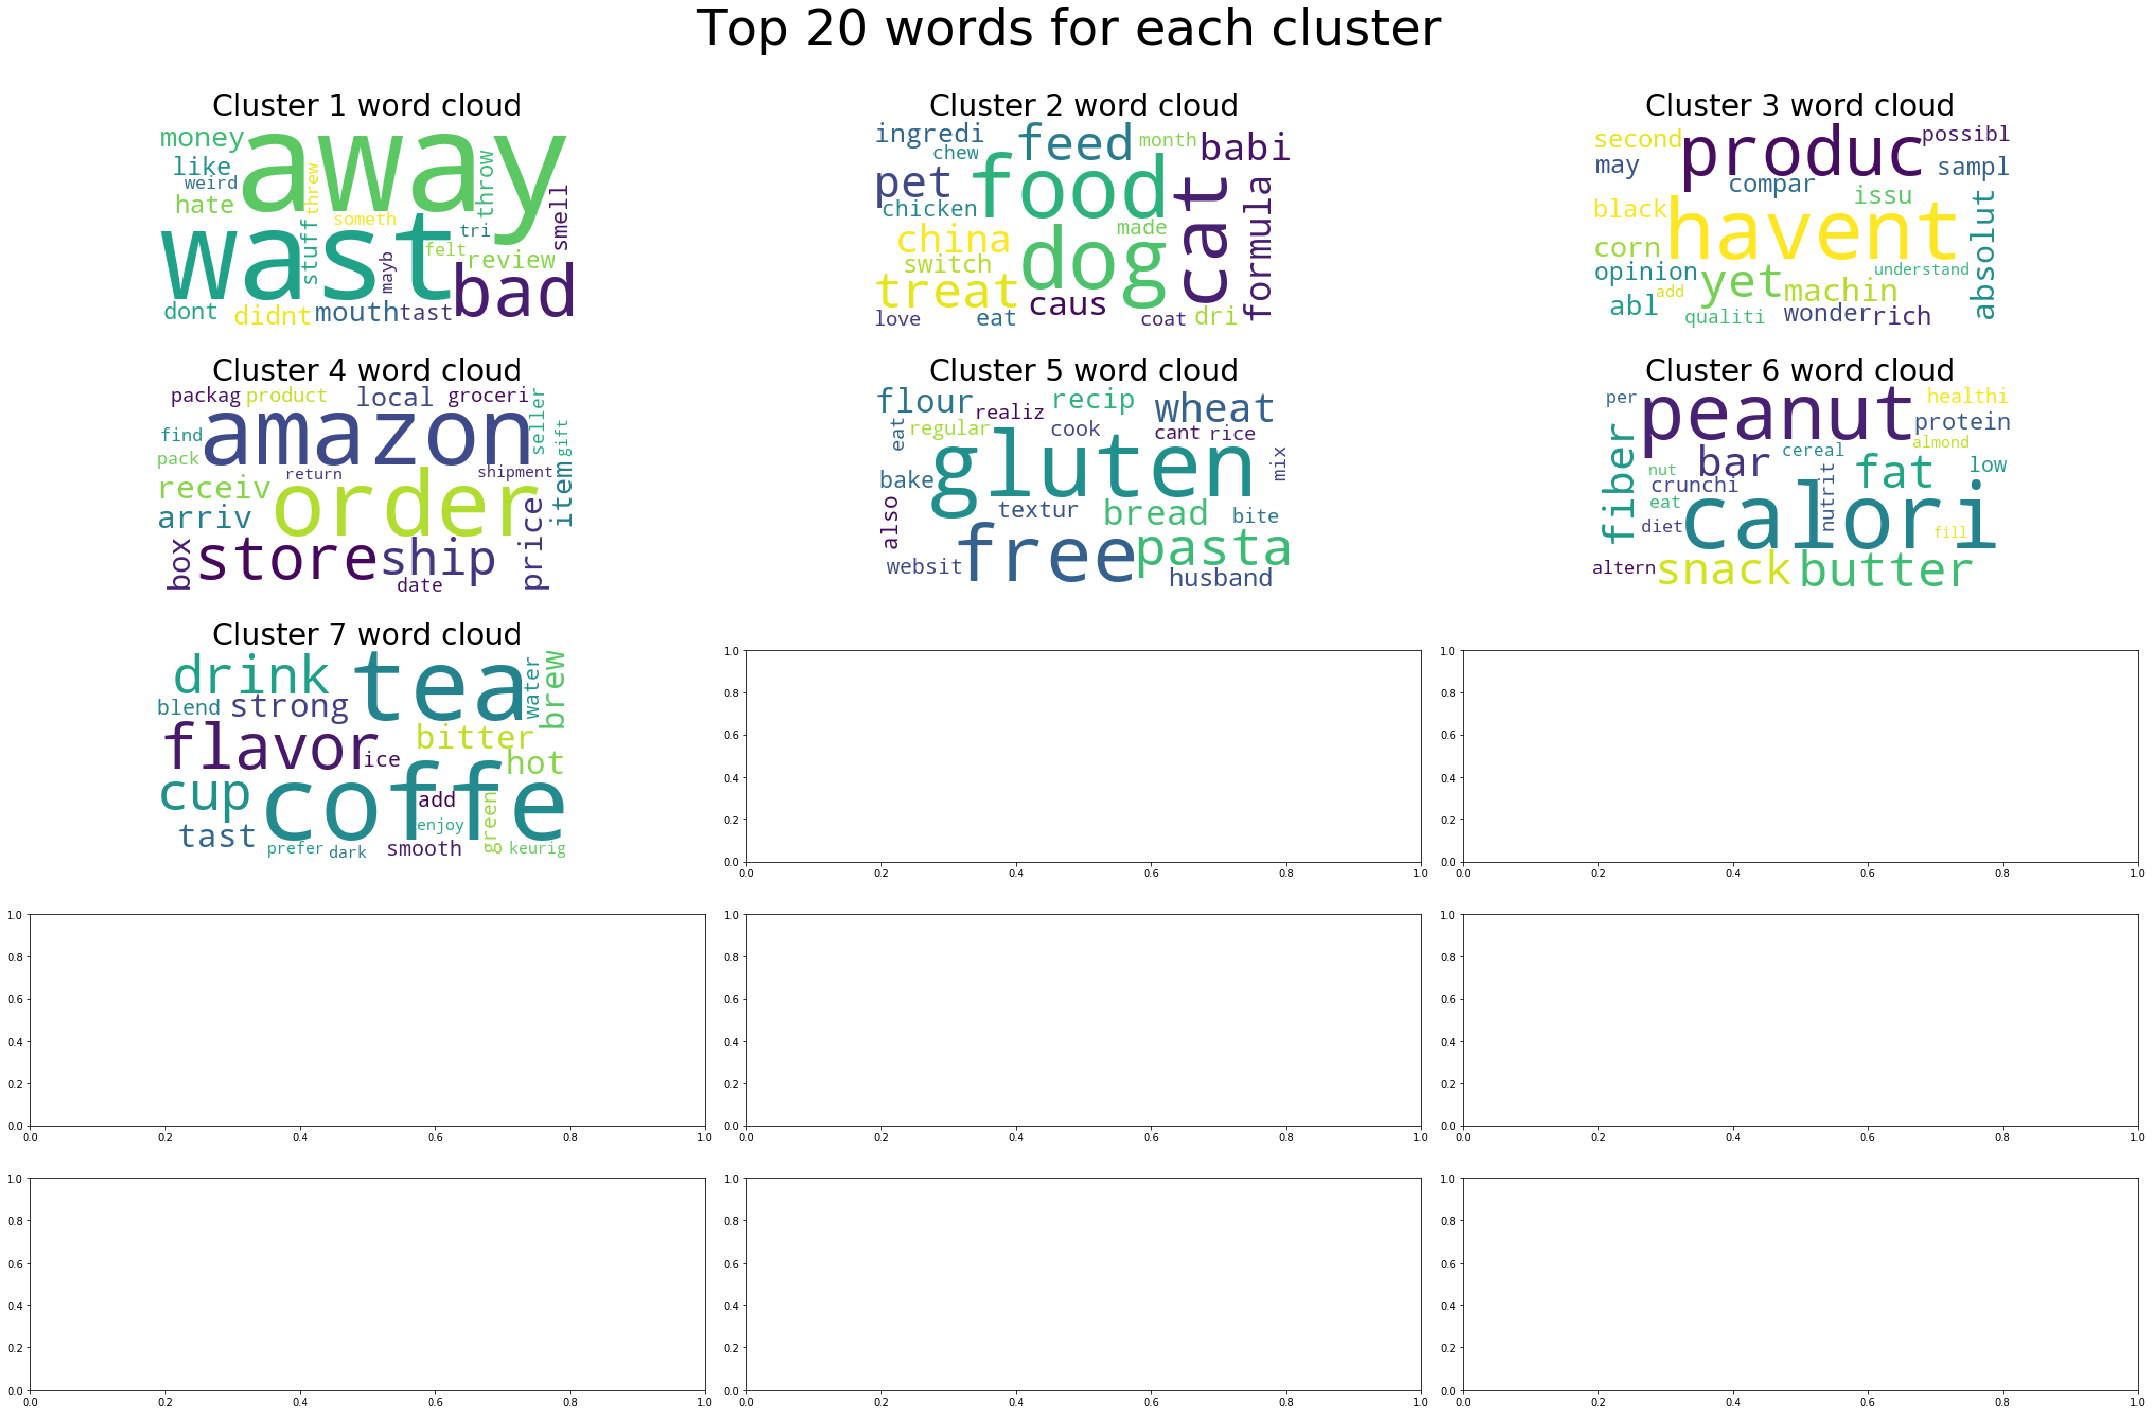

In [43]:
# getting feature names in features 
# and the cluster centers in coef
# Plot the all cluster with their corresponding features
features = model.get_feature_names()
coef = clf.cluster_centers_
plot_cluster_cloud(features, coef)#will get us top 20 words in each cluster

## 4. Word2Vec

In [44]:
#splitting each of my reviews in x_train into list of, list of stemmed words in each of our stemmed reviews in x_train
list_of_sent = []
for sent in x.values:
    list_of_sent.append(sent.split())

In [45]:
w2v_model = Word2Vec(list_of_sent,min_count = 5,size = 50,workers = 4) #Here I am creating word2vec representation of each of-
#- the words in my 'list_of_sent' list i.e I am creating w2v representation of words in reviews of x_train, where we-
#- are creating word2vec vectors for words in 'list_of_sent' list which-
#- occur >=5 times in the list. The number of dimensions of our word2ec vectors = 50 and number of cores which will carry-
#- on the job parallely = 4
print(w2v_model) #returns an iterator
#to see which words exist in our w2v-model
w2v_words = list(w2v_model.wv.vocab)#Here we are creating list of words, which are keys in dictionary 'w2v_model.wv.vocab'.
print(w2v_words)

Word2Vec(vocab=3329, size=50, alpha=0.025)


['movi', 'cant', 'watch', 'time', 'one', 'ever', 'made', 'mix', 'strang', 'realiti', 'stori', 'along', 'funni', 'thing', 'world', 'live', 'dead', 'recent', 'wait', 'hous', 'year', 'peopl', 'come', 'tri', 'break', 'cover', 'take', 'place', 'excel', 'job', 'see', 'definit', 'guilti', 'pleasur', 'often', 'think', 'suppos', 'like', 'film', 'help', 'make', 'solid', 'also', 'feel', 'great', 'product', 'valu', 'sens', 'abil', 'delight', 'everyon', 'famili', 'love', 'chees', 'especi', 'french', 'spanish', 'receiv', 'assort', 'gift', 'realli', 'favorit', 'group', 'decad', 'rich', 'creami', 'flavor', 'transport', 'back', 'day', 'student', 'way', 'across', 'europ', 'neither', 'wife', 'sharp', 'tangi', 'ate', 'much', 'smaller', 'portion', 'never', 'either', 'say', 'smoki', 'becom', 'even', 'perfect', 'weather', 'nibbl', 'appl', 'loaf', 'bread', 'glass', 'divin', 'special', 'share', 'friend', 'wonder', 'lover', 'life', 'open', 'outstand', 'intend', 'use', 'mixtur', 'meatbal', 'decid', 'delici', 'en

## 4.1 Average Word2Vec

In [46]:
#average word2vec for each review in x_train
sent_vectors = []
for sent in tqdm(list_of_sent): #tqdm displays a progress bar. The progress bar tells us the rate at which-
    #-the looping operation is taking place
    sent_vec = np.zeros(50)# here we are creating numpy array of 50 zeros
    cnt_words = 0; #this variable will be used to count the number of words in each element (which is a list) of 'list_of_sent'
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]#here we are storing the word2vec representation of each word in sent-
            #- which is in 'w2v_words' list
            sent_vec += vec #here we are adding all the w2v vectors for each word in a review(or sent)
            cnt_words +=1
    if cnt_words!=0:
        sent_vec/=cnt_words #here we are calculating average w2v for each review(or sent) in x_train
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:12<00:00, 416.01it/s]


5000
50


In [47]:
avg_w2v_x = pd.DataFrame(sent_vectors)
standardized_x = StandardScaler().fit_transform(avg_w2v_x)

### 4.1.1 KMeans on Avg. W2V

In [48]:
### 2.1 K-Means on BOW
k=[1,2,3,4,5,6,7,8]
dic=dict()
for i in k:
    clf=KMeans(n_clusters=i)
    clf.fit(standardized_x)
    dic[i] = clf.inertia_

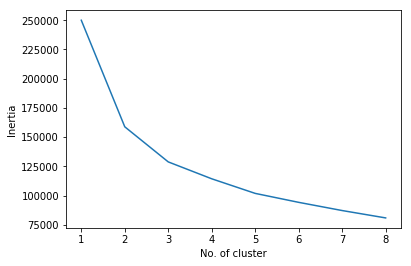

In [49]:
plt.plot(list(dic.keys()), list(dic.values()))
plt.xlabel("No. of cluster")
plt.ylabel("Inertia")
plt.show()

In [50]:
clf = KMeans(n_clusters = 3)
clf.fit(standardized_x)
pred=clf.predict(standardized_x)

In [54]:
clf.labels_.shape[0]

5000

In [59]:
cluster1,cluster2,cluster3,cluster4=[],[],[],[]
for i in range(clf.labels_.shape[0]):
    if clf.labels_[i] == 0:
        cluster1.append(x.values[i])
    elif clf.labels_[i] == 1:
        cluster2.append(x.values[i])
    else:
        cluster3.append(x.values[i])

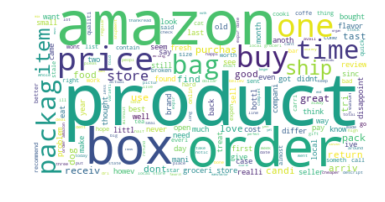

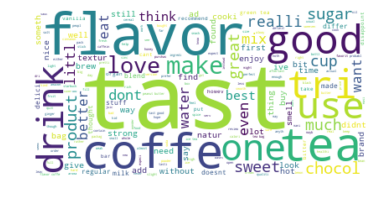

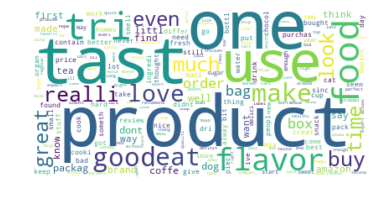

In [61]:
def word_cloud(cluster):
    data=''
    for i in cluster:
        data+=str(i)
    from wordcloud import WordCloud
    wordcloud = WordCloud(background_color="white").generate(data)

    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

cluster_list=[cluster1,cluster2,cluster3]
for i in cluster_list:
    word_cloud(i)

### 4.1.2 Agglomerative clustering on Avg. W2V

In [66]:
clf=AgglomerativeClustering(n_clusters = 3)#As there is no way of plotting elow diagram in Agglomerative clustering there-
#-fore, here we are taking no. of clusters by our choice. For a specific number of clusters we will get a perfect-
#- clustering. So it is a kind of hit and trial method.
clf.fit(standardized_x)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=3,
            pooling_func='deprecated')

In [67]:
cluster1,cluster2,cluster3,cluster4=[],[],[],[]
for i in range(clf.labels_.shape[0]):
    if clf.labels_[i] == 0:
        cluster1.append(x.values[i])
    elif clf.labels_[i] == 1:
        cluster2.append(x.values[i])
    else:
        cluster3.append(x.values[i])

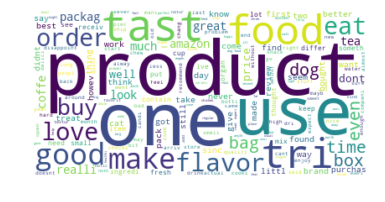

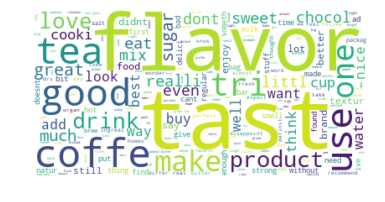

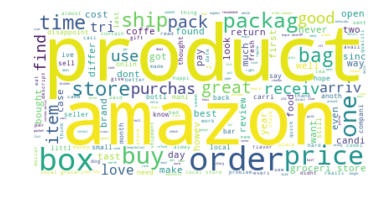

In [68]:
def word_cloud(cluster):
    data=''
    for i in cluster:
        data+=str(i)
    from wordcloud import WordCloud
    wordcloud = WordCloud(background_color="white").generate(data)

    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

cluster_list=[cluster1,cluster2,cluster3]
for i in cluster_list:
    word_cloud(i)

### 4.1.3 DBSCAN on Avg. W2V

In [69]:
min_point = 100
knn = NearestNeighbors(n_neighbors = min_point)
knn.fit(standardized_x)
dist , index = knn.kneighbors(standardized_x)

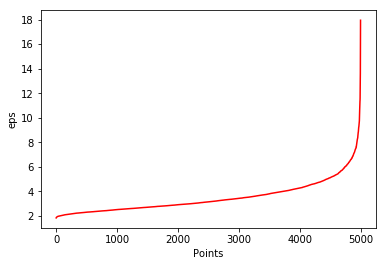

In [71]:
sort = sorted(dist[:,min_point-1])
plt.plot(list(range(1,len(standardized_x)+1)),sort,'r-')
plt.xlabel('Points')
plt.ylabel('eps')
plt.show()

In [74]:
clf = DBSCAN(eps = 7 , min_samples = 100)
clf.fit(standardized_x)

DBSCAN(algorithm='auto', eps=7, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=100, n_jobs=None, p=None)

In [75]:
cluster1,cluster2,cluster3,cluster4=[],[],[],[]
for i in range(clf.labels_.shape[0]):
    if clf.labels_[i] == 0:
        cluster1.append(x.values[i])
    elif clf.labels_[i] == 1:
        cluster2.append(x.values[i])
    else:
        cluster3.append(x.values[i])

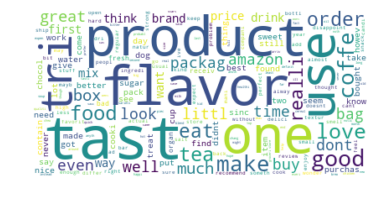

ValueError: We need at least 1 word to plot a word cloud, got 0.

In [76]:
cluster_list=[cluster1,cluster2,cluster3]
for i in cluster_list:
    word_cloud(i)
#Below we will be able to see that only one cluster was formed.

### 4.2 Weighted W2V

In [ ]:
#tf-idf on train dataset
vectorizer = TfidfVectorizer()#defining our tf-idf model and considering only those words which occur more than 50-
#times in our document
model = vectorizer.fit(x_train)#Here we are learning the internal parameters (i.e vocabulary) of our train dataset-
#- (i.e. review text)
print(vectorizer.vocabulary_) #visualizing the parameters learnt (i.e vocabulary)

In [ ]:
#creating dictionary, where keys are words in our dataset and values are their corresponding idf values
dictionary_1 = dict(zip(model.get_feature_names(),list(model.idf_)))

In [ ]:
#Weighted word2vec for x_train
tfidf_sent_vectors_x = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary_1[word]*(sent.count(word)/len(sent)) # dictionary[word] = idf value of word in whole courpus-
            #- sent.count(word) = tf valeus of word in this review 
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_x.append(sent_vec)
    row += 1
print(len(tfidf_sent_vectors_x))
print(len(tfidf_sent_vectors_x[0]))

In [ ]:
tfidf_w2v_x = pd.DataFrame(tfidf_sent_vectors_x)
standardized_x = StandardScaler().fit_transform(tfidf_w2v_x)

### 4.2.1 KMeans on Weighted W2V

In [78]:
### 2.1 K-Means on BOW
k=[1,2,3,4,5,6,7,8]
dic=dict()
for i in k:
    clf=KMeans(n_clusters=i)
    clf.fit(standardized_x)
    dic[i] = clf.inertia_

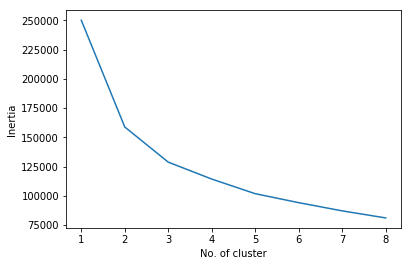

In [79]:
plt.plot(list(dic.keys()), list(dic.values()))
plt.xlabel("No. of cluster")
plt.ylabel("Inertia")
plt.show()

In [80]:
clf = KMeans(n_clusters = 2)
clf.fit(standardized_x)
pred=clf.predict(standardized_x)

In [81]:
cluster1,cluster2,cluster3,cluster4=[],[],[],[]
for i in range(clf.labels_.shape[0]):
    if clf.labels_[i] == 0:
        cluster1.append(x.values[i])
    elif clf.labels_[i] == 1:
        cluster2.append(x.values[i])
    else:
        cluster3.append(x.values[i])

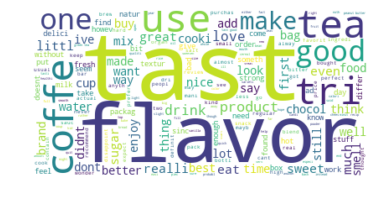

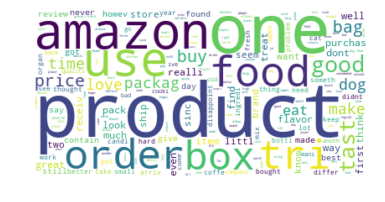

In [82]:
cluster_list=[cluster1,cluster2]
for i in cluster_list:
    word_cloud(i)

### 4.2.2 Agglomerative Clustering on Weighted W2V

In [83]:
clf=AgglomerativeClustering(n_clusters = 3)#As there is no way of plotting elow diagram in Agglomerative clustering there-
#-fore, here we are taking no. of clusters by our choice. For a specific number of clusters we will get a perfect-
#- clustering. So it is a kind of hit and trial method.
clf.fit(standardized_x)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=3,
            pooling_func='deprecated')

In [84]:
cluster1,cluster2,cluster3,cluster4=[],[],[],[]
for i in range(clf.labels_.shape[0]):
    if clf.labels_[i] == 0:
        cluster1.append(x.values[i])
    elif clf.labels_[i] == 1:
        cluster2.append(x.values[i])
    else:
        cluster3.append(x.values[i])

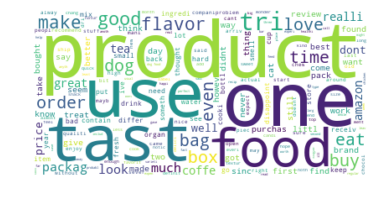

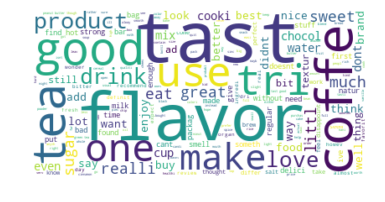

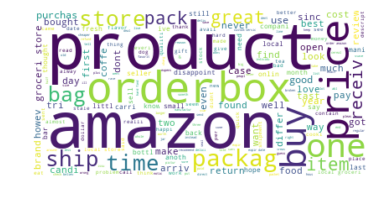

In [86]:
cluster_list=[cluster1,cluster2,cluster3]
for i in cluster_list:
    word_cloud(i)

### 4.2.3 DBSCAN on Weighted W2V

In [87]:
min_point = 100
knn = NearestNeighbors(n_neighbors = min_point)
knn.fit(standardized_x)
dist , index = knn.kneighbors(standardized_x)

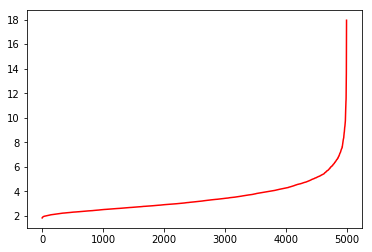

In [88]:
sort = sorted(dist[:,min_point-1])
plt.plot(list(range(1,len(standardized_x)+1)),sort,'r-')
plt.show()

In [89]:
clf = DBSCAN(eps = 7 , min_samples = 100)
clf.fit(standardized_x)

DBSCAN(algorithm='auto', eps=7, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=100, n_jobs=None, p=None)

In [90]:
cluster1,cluster2,cluster3,cluster4=[],[],[],[]
for i in range(clf.labels_.shape[0]):
    if clf.labels_[i] == 0:
        cluster1.append(x.values[i])
    elif clf.labels_[i] == 1:
        cluster2.append(x.values[i])
    else:
        cluster3.append(x.values[i])

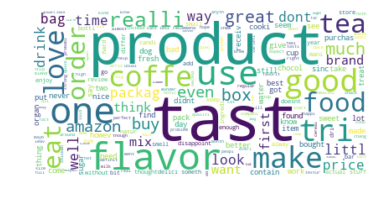

ValueError: We need at least 1 word to plot a word cloud, got 0.

In [91]:
cluster_list=[cluster1,cluster2,cluster3]
for i in cluster_list:
    word_cloud(i)

# [6] Conclusions

In [4]:
# Please compare all your models using Prettytable library. 
# You can have 3 tables, one each for kmeans, agllomerative and dbscan